In [19]:
from pathlib import Path
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import  ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC

In [2]:
def load_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/titanic.tgz'
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_file:
            titanic_file.extractall(path = 'datasets')
    return [pd.read_csv(Path('datasets/titanic') / filename) for filename in ('train.csv', 'test.csv')]

In [3]:
train_data, test_data = load_data()

In [4]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [9]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False))
])

num_attr = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attr = ['Pclass', 'Sex', 'Embarked']

process_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attr),
    ('cat', cat_pipeline, cat_attr)
])

X_train = process_pipeline.fit_transform(train_data)
y_train = train_data['Survived']

In [12]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
X_test = process_pipeline.fit_transform(test_data)
y_pred = forest_clf.predict(X_test)

In [16]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

In [18]:
svm_clf = SVC(gamma='auto')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores.mean()

0.8249313358302123

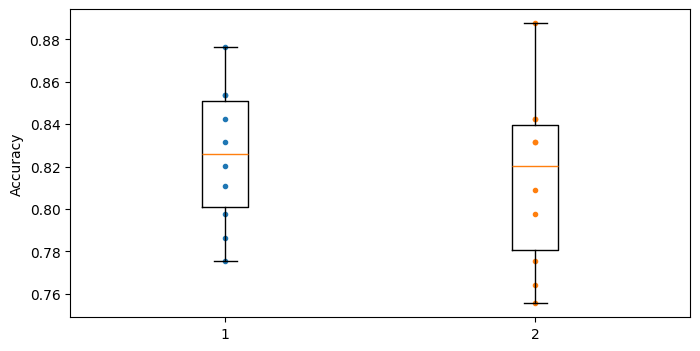

In [24]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], label=('SVM', 'Random Forest'))
plt.ylabel('Accuracy')
plt.show()